# B.2 : survival analysis problem, logistic regression, impact of SBS / INDEL signatures
In this notebook, we compare, for the survival analysis problem with the Cox Model, the following configurations :
- with only SBS mutational signatures
- with only INDEL mutational signatures
- with combination of both

## Table of contents

1. [Only SBS mutational signatures](#1-sbs)
2. [Only INDEL mutational signatures](#2-indel)
3. [SBS + INDEL mutational signatures](#3-comb)
4. [Evaluate performances](#4-performances)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import torch

from evaluation.SurvivalMetrics import SurvivalMetrics

from manage.CoxTrainTestManager import CoxTrainTestManager

from sklearn.preprocessing import StandardScaler

from utils.featureSelection import featureSelection
from utils.preProcessing import preProcessing

#### Set hyper-parameters

In [18]:
n_features = 5

#### Reading and preprocessing

In [19]:
# Reading dataset
df = pd.read_excel('data/cohort-dataset.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = preProcessing.delete_nan_values(df)

# Relabel patients (t = 183 days = 6 months)
t = 183
df = preProcessing.relabel_patients(df, "Progression_1", "Time to progression (days)", t)
df = preProcessing.relabel_patients(df, "Alive_0", "Overall survival (days)", t)

# Extract labels
# TTP :
y_cox_ttp = np.array(list((df[['Progression_1', 'Time to progression (days)']].itertuples(index=False, name=None))),
                        dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])

# OS :
y_cox_os = np.array(list((df[['Alive_0', 'Overall survival (days)']].itertuples(index=False, name=None))),
                    dtype=[('Alive_0', '?'), ('Overall survival (days)', '<f8')])

### 1. Only SBS mutational signatures

#### Feature selection

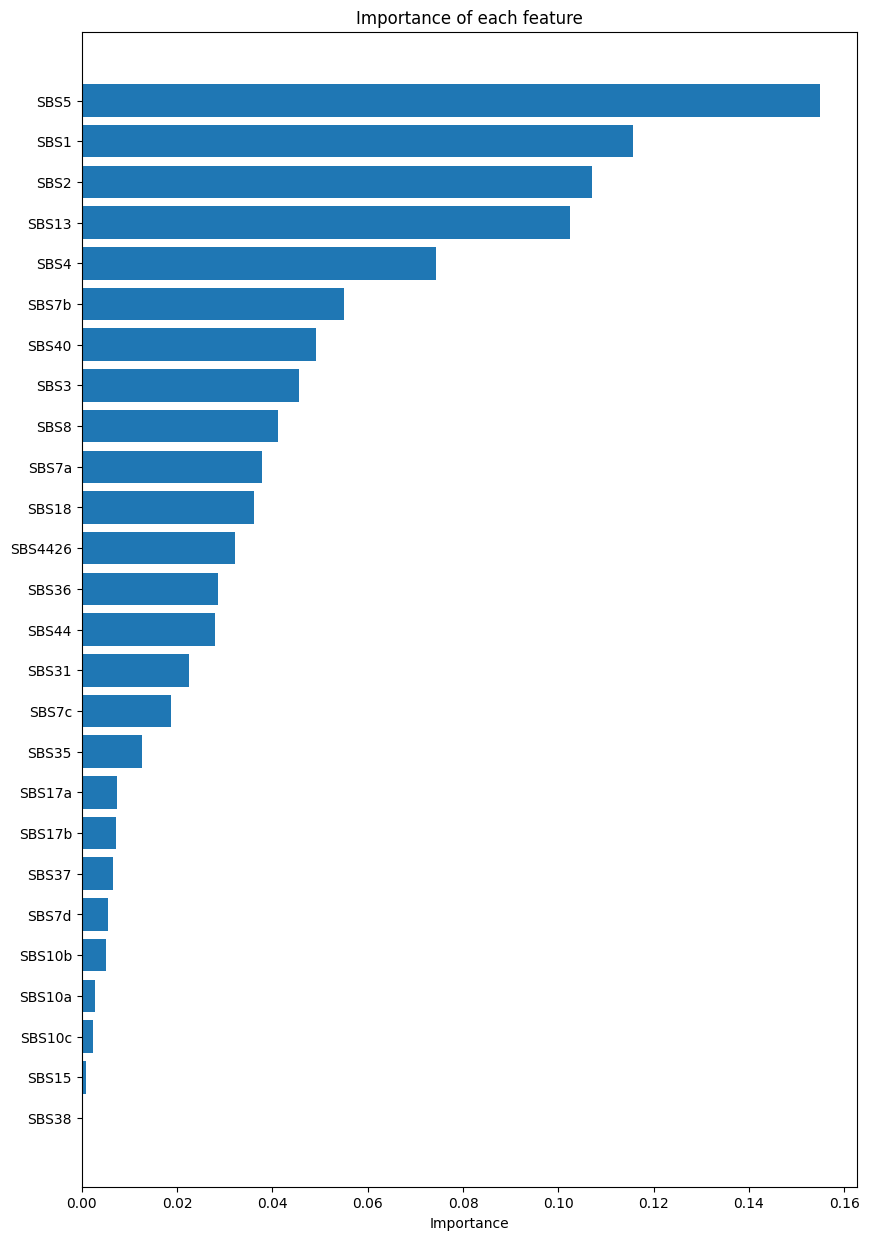

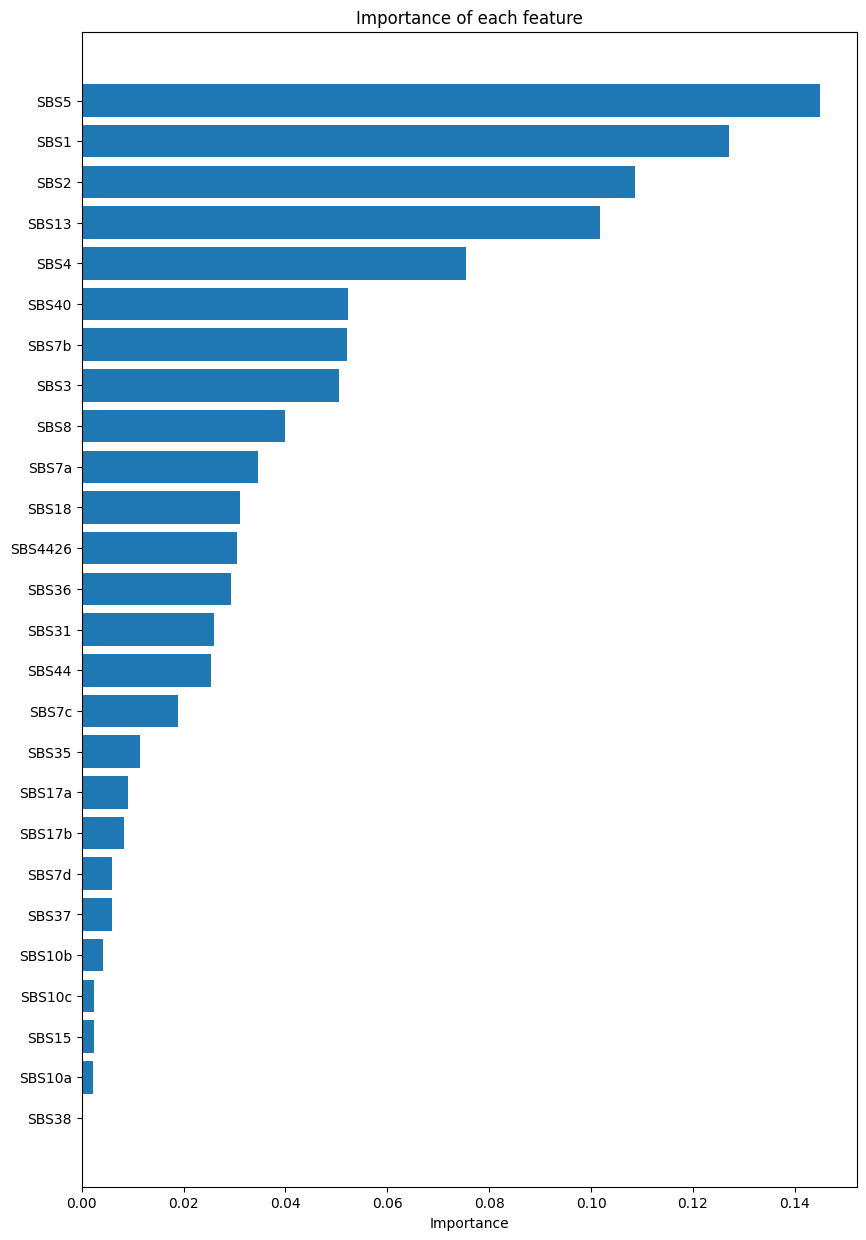

In [20]:
features_name_sbs = ["SBS1",
                     "SBS2",
                     "SBS3",
                     "SBS4",
                     "SBS5",
                     "SBS7a",
                     "SBS7b",
                     "SBS7c",
                     "SBS7d",
                     "SBS8",
                     "SBS10a",
                     "SBS10b",
                     "SBS10c",
                     "SBS13",
                     "SBS15",
                     "SBS17a",
                     "SBS17b",
                     "SBS18",
                     "SBS31",
                     "SBS35",
                     "SBS36",
                     "SBS37",
                     "SBS38",
                     "SBS40",
                     "SBS44",
                     "SBS4426"]

# Compute feature importance
# TTP :
features_name_sbs_ttp = featureSelection.feature_importance(df.loc[:, features_name_sbs],
                                                        y_cox_ttp,
                                                        True)
features_name_sbs_os = featureSelection.feature_importance(df.loc[:, features_name_sbs],
                                                        y_cox_os,
                                                        True)

# Select the most n_features important features
if n_features < len(features_name_sbs):
    features_name_sbs_ttp = features_name_sbs_ttp[:n_features]
    features_name_sbs_os = features_name_sbs_os[:n_features]

# Extract features
X_sbs_ttp = df.loc[:, features_name_sbs_ttp].to_numpy()
X_sbs_os = df.loc[:, features_name_sbs_os].to_numpy()

#### Make the leave one out CV

In [21]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_sbs_ttp = CoxTrainTestManager()
risk_scores_sbs_ttp, risk_classes_sbs_ttp = manager_sbs_ttp.leave_one_out_cv(X_sbs_ttp,
                                                                                               y_cox_ttp)
# OS :
manager_sbs_os = CoxTrainTestManager()
risk_scores_sbs_os, risk_classes_sbs_os = manager_sbs_os.leave_one_out_cv(X_sbs_os,
                                                                                            y_cox_os)

### 2. Only INDEL mutational signatures

#### Feature selection

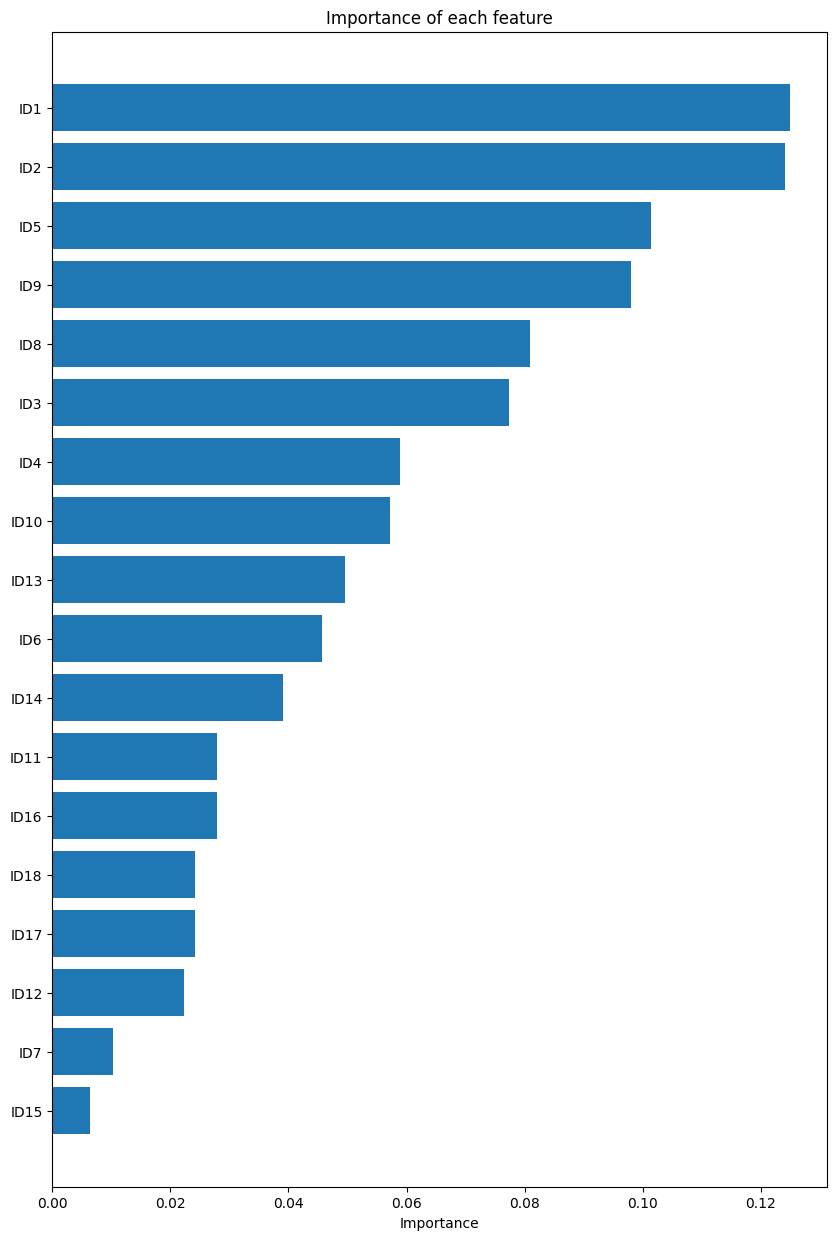

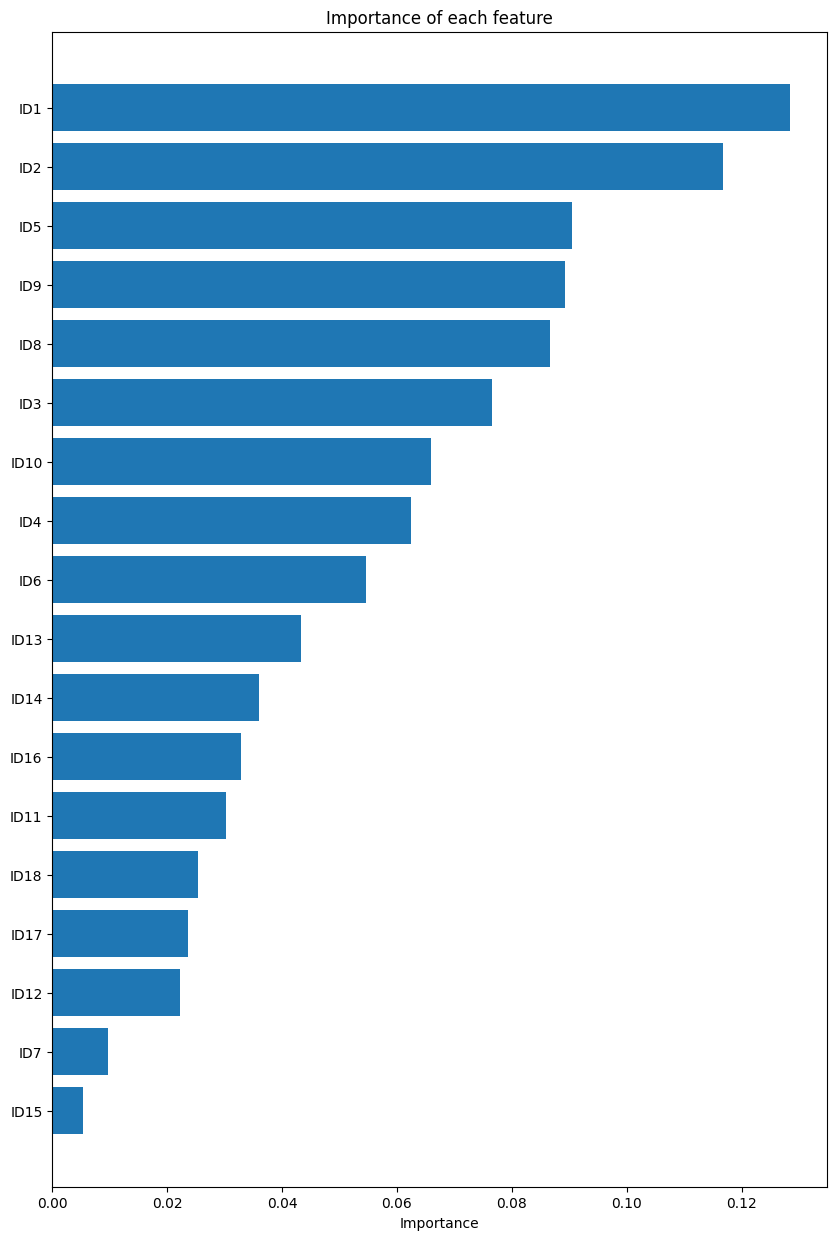

In [22]:
features_name_indel = ["ID1",
                       "ID2",
                       "ID3",
                       "ID4",
                       "ID5",
                       "ID6",
                       "ID7",
                       "ID8",
                       "ID9",
                       "ID10",
                       "ID11",
                       "ID12",
                       "ID13",
                       "ID14",
                       "ID15",
                       "ID16",
                       "ID17",
                       "ID18"]

# Compute feature importance
# TTP :
features_name_indel_ttp = featureSelection.feature_importance(df.loc[:, features_name_indel],
                                                        y_cox_ttp,
                                                        True)
features_name_indel_os = featureSelection.feature_importance(df.loc[:, features_name_indel],
                                                        y_cox_os,
                                                        True)

# Select the most n_features important features
if n_features < len(features_name_indel):
    features_name_indel_ttp = features_name_indel_ttp[:n_features]
    features_name_indel_os = features_name_indel_os[:n_features]

# Extract features
X_indel_ttp = df.loc[:, features_name_indel_ttp].to_numpy()
X_indel_os = df.loc[:, features_name_indel_os].to_numpy()

#### Make the leave one out CV

In [23]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_indel_ttp = CoxTrainTestManager()
risk_scores_indel_ttp, risk_classes_indel_ttp = manager_indel_ttp.leave_one_out_cv(X_indel_ttp, y_cox_ttp)
# OS :
manager_indel_os = CoxTrainTestManager()
risk_scores_indel_os, risk_classes_indel_os = manager_indel_os.leave_one_out_cv(X_indel_os, y_cox_os)

### 3. SBS + INDEL mutational signatures

#### Feature selection

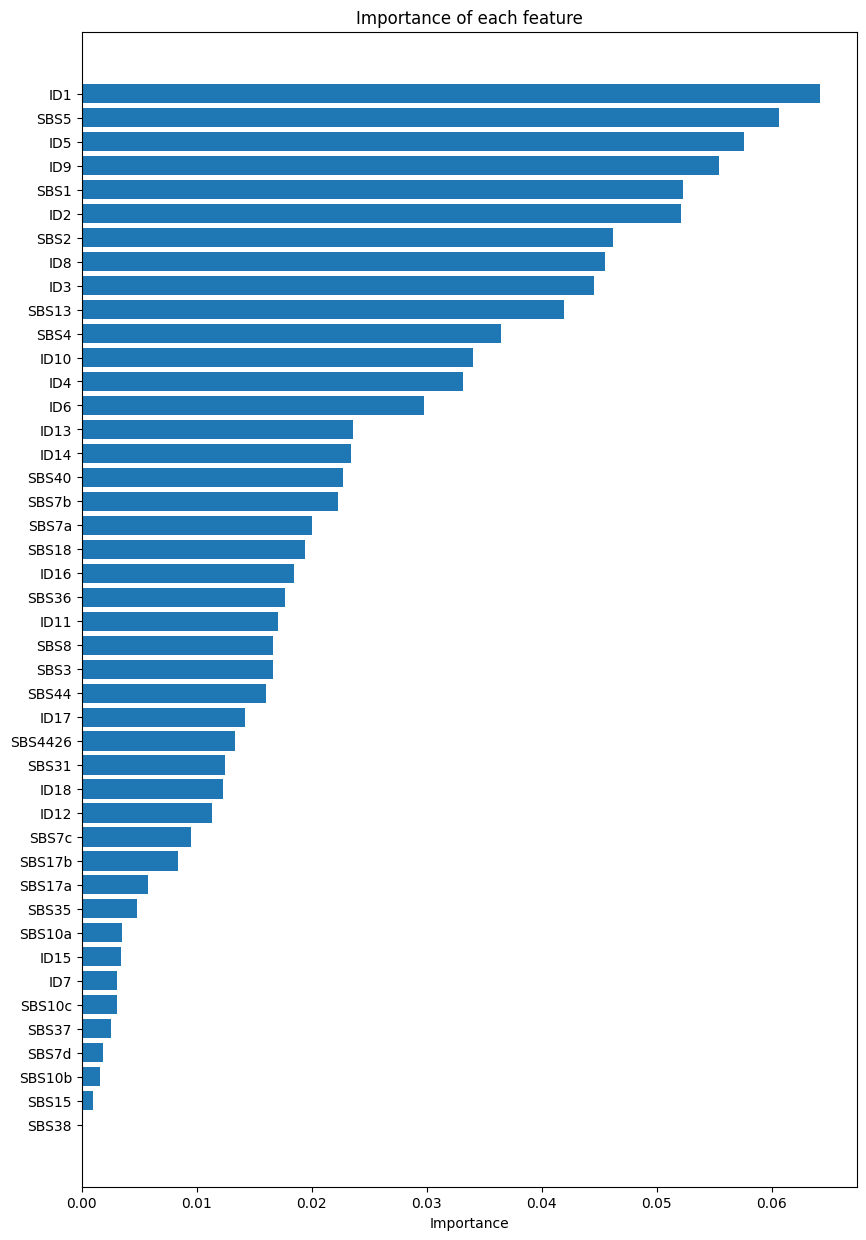

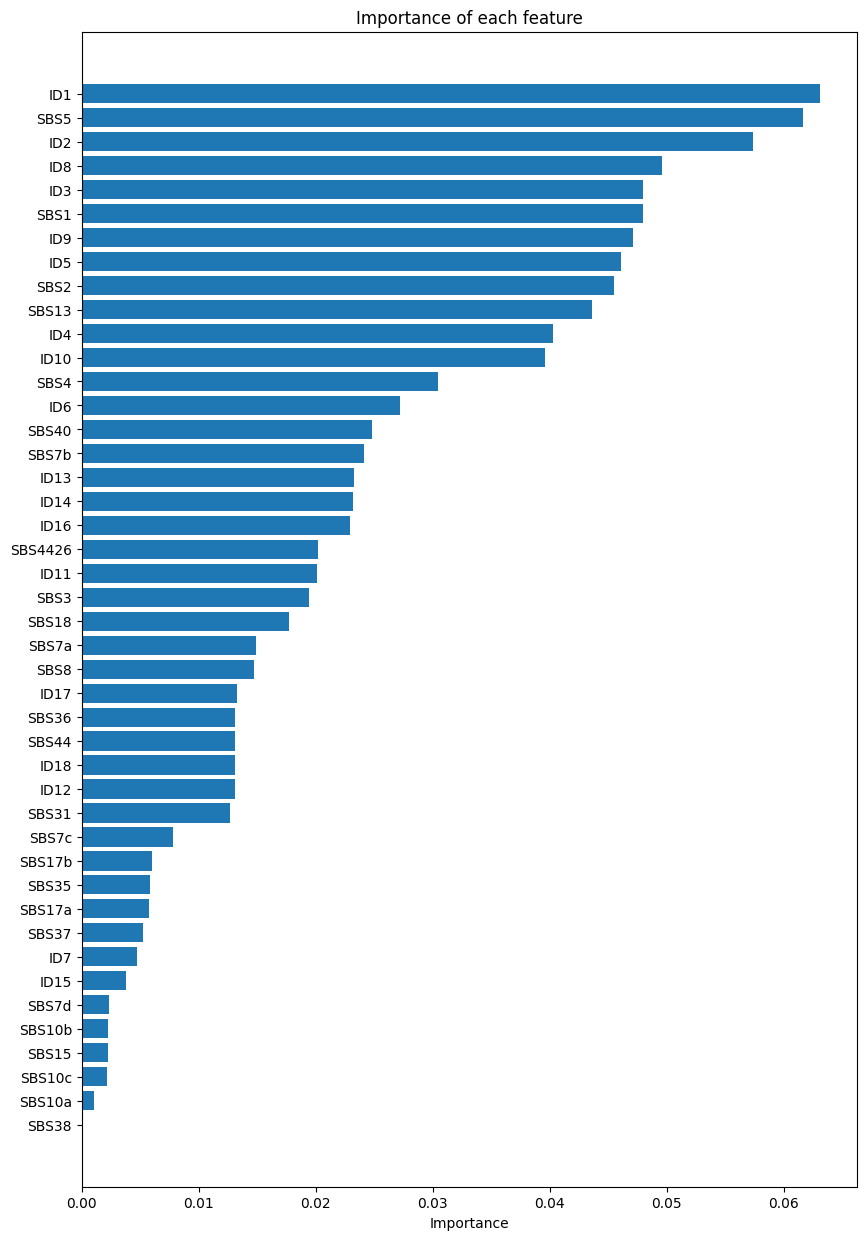

In [24]:
features_name_comb = ["SBS1",
                      "SBS2",
                      "SBS3",
                      "SBS4",
                      "SBS5",
                      "SBS7a",
                      "SBS7b",
                      "SBS7c",
                      "SBS7d",
                      "SBS8",
                      "SBS10a",
                      "SBS10b",
                      "SBS10c",
                      "SBS13",
                      "SBS15",
                      "SBS17a",
                      "SBS17b",
                      "SBS18",
                      "SBS31",
                      "SBS35",
                      "SBS36",
                      "SBS37",
                      "SBS38",
                      "SBS40",
                      "SBS44",
                      "SBS4426",
                      "ID1",
                      "ID2",
                      "ID3",
                      "ID4",
                      "ID5",
                      "ID6",
                      "ID7",
                      "ID8",
                      "ID9",
                      "ID10",
                      "ID11",
                      "ID12",
                      "ID13",
                      "ID14",
                      "ID15",
                      "ID16",
                      "ID17",
                      "ID18"]

# Compute feature importance
# TTP :
features_name_comb_ttp = featureSelection.feature_importance(df.loc[:, features_name_comb], y_cox_ttp, True)
features_name_comb_os = featureSelection.feature_importance(df.loc[:, features_name_comb], y_cox_os, True)

# Select the most n_features important features
if n_features < len(features_name_comb):
    features_name_comb_ttp = features_name_comb_ttp[:n_features]
    features_name_comb_os = features_name_comb_os[:n_features]

# Extract features
X_comb_ttp = df.loc[:, features_name_comb_ttp].to_numpy()
X_comb_os = df.loc[:, features_name_comb_os].to_numpy()

#### Make the leave one out CV

In [25]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_comb_ttp = CoxTrainTestManager()
risk_scores_comb_ttp, risk_classes_comb_ttp = manager_comb_ttp.leave_one_out_cv(X_comb_ttp, y_cox_ttp)
# OS :
manager_comb_os = CoxTrainTestManager()
risk_scores_comb_os, risk_classes_comb_os = manager_comb_os.leave_one_out_cv(X_comb_os, y_cox_os)

### 4. Evaluate performances

In [26]:
status_ttp, time_ttp = df['Progression_1'].to_numpy().astype(bool), df['Time to progression (days)'].to_numpy()
status_os, time_os = df['Alive_0'].to_numpy().astype(bool), df['Overall survival (days)'].to_numpy()

#### SHAP values

In [27]:
# SBS
# TTP :
explainer_sbs_ttp = shap.Explainer(manager_sbs_ttp.model.model.predict, X_sbs_ttp)
shap_values_sbs_ttp = explainer_sbs_ttp(X_sbs_ttp)
# OS :
explainer_sbs_os = shap.Explainer(manager_sbs_os.model.model.predict, X_sbs_os)
shap_values_sbs_os = explainer_sbs_os(X_sbs_os)

# INDEL
# TTP :
explainer_indel_ttp = shap.Explainer(manager_indel_ttp.model.model.predict, X_indel_ttp)
shap_values_indel_ttp = explainer_indel_ttp(X_indel_ttp)
# OS :
explainer_indel_os = shap.Explainer(manager_indel_os.model.model.predict, X_indel_os)
shap_values_indel_os = explainer_indel_os(X_indel_os)

# SBS + INDEL
# TTP :
explainer_comb_ttp = shap.Explainer(manager_comb_ttp.model.model.predict, X_comb_ttp)
shap_values_comb_ttp = explainer_comb_ttp(X_comb_ttp)
# OS :
explainer_comb_os = shap.Explainer(manager_comb_os.model.model.predict, X_comb_os)
shap_values_comb_os = explainer_comb_os(X_comb_os)

#### C-index

In [28]:
# SBS
c_index_sbs_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_sbs_ttp)
c_index_sbs_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_sbs_os)

# INDEL
c_index_indel_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_indel_ttp)
c_index_indel_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_indel_os)

# SBS + INDEL
c_index_comb_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_comb_ttp)
c_index_comb_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_comb_os)

#### Log rank test p value

In [29]:
# SBS
p_value_sbs_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                            time_ttp,*
                                                            risk_classes_sbs_ttp)
p_value_sbs_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                           time_os,
                                                            risk_classes_sbs_os)

# INDEL
p_value_indel_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                              time_ttp,
                                                              risk_classes_indel_ttp)
p_value_indel_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                             time_os,
                                                             risk_classes_indel_os)

# SBS + INDEL
p_value_comb_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                             time_ttp,
                                                             risk_classes_comb_ttp)
p_value_comb_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                            time_os,
                                                            risk_classes_comb_os)

#### Kaplan Meier curves

In [30]:
# SBS
# TTP, low risk :
status_low_risk_sbs_ttp = status_ttp[np.where(risk_classes_sbs_ttp == 0)]
time_low_risk_sbs_ttp = time_ttp[np.where(risk_classes_sbs_ttp == 0)]
time_axis_low_risk_sbs_ttp, prob_axis_low_risk_sbs_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_sbs_ttp, time_low_risk_sbs_ttp)
# TTP, high risk :
status_high_risk_sbs_ttp = status_ttp[np.where(risk_classes_sbs_ttp == 1)]
time_high_risk_sbs_ttp = time_ttp[np.where(risk_classes_sbs_ttp == 1)]
time_axis_high_risk_sbs_ttp, prob_axis_high_risk_sbs_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_sbs_ttp, time_high_risk_sbs_ttp)
# OS, low risk :
status_low_risk_sbs_os = status_os[np.where(risk_classes_sbs_os == 0)]
time_low_risk_sbs_os = time_os[np.where(risk_classes_sbs_os == 0)]
time_axis_low_risk_sbs_os, prob_axis_low_risk_sbs_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_sbs_os, time_low_risk_sbs_os)
# OS, high risk :
status_high_risk_sbs_os = status_os[np.where(risk_classes_sbs_os == 1)]
time_high_risk_sbs_os = time_os[np.where(risk_classes_sbs_os == 1)]
time_axis_high_risk_sbs_os, prob_axis_high_risk_sbs_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_sbs_os, time_high_risk_sbs_os)

# INDEL
# TTP, low risk :
status_low_risk_indel_ttp = status_ttp[np.where(risk_classes_indel_ttp == 0)]
time_low_risk_indel_ttp = time_ttp[np.where(risk_classes_indel_ttp == 0)]
time_axis_low_risk_indel_ttp, prob_axis_low_risk_indel_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_indel_ttp, time_low_risk_indel_ttp)
# TTP, high risk :
status_high_risk_indel_ttp = status_ttp[np.where(risk_classes_indel_ttp == 1)]
time_high_risk_indel_ttp = time_ttp[np.where(risk_classes_indel_ttp == 1)]
time_axis_high_risk_indel_ttp, prob_axis_high_risk_indel_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_indel_ttp, time_high_risk_indel_ttp)
# OS, low risk :
status_low_risk_indel_os = status_os[np.where(risk_classes_indel_os == 0)]
time_low_risk_indel_os = time_os[np.where(risk_classes_indel_os == 0)]
time_axis_low_risk_indel_os, prob_axis_low_risk_indel_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_indel_os, time_low_risk_indel_os)
# OS, high risk :
status_high_risk_indel_os = status_os[np.where(risk_classes_indel_os == 1)]
time_high_risk_indel_os = time_os[np.where(risk_classes_indel_os == 1)]
time_axis_high_risk_indel_os, prob_axis_high_risk_indel_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_indel_os, time_high_risk_indel_os)

# SBS + INDEL
# TTP, low risk :
status_low_risk_comb_ttp = status_ttp[np.where(risk_classes_comb_ttp == 0)]
time_low_risk_comb_ttp = time_ttp[np.where(risk_classes_comb_ttp == 0)]
time_axis_low_risk_comb_ttp, prob_axis_low_risk_comb_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_comb_ttp, time_low_risk_comb_ttp)
# TTP, high risk :
status_high_risk_comb_ttp = status_ttp[np.where(risk_classes_comb_ttp == 1)]
time_high_risk_comb_ttp = time_ttp[np.where(risk_classes_comb_ttp == 1)]
time_axis_high_risk_comb_ttp, prob_axis_high_risk_comb_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_comb_ttp, time_high_risk_comb_ttp)
# OS, low risk :
status_low_risk_comb_os = status_os[np.where(risk_classes_comb_os == 0)]
time_low_risk_comb_os = time_os[np.where(risk_classes_comb_os == 0)]
time_axis_low_risk_comb_os, prob_axis_low_risk_comb_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_comb_os, time_low_risk_comb_os)
# OS, high risk :
status_high_risk_comb_os = status_os[np.where(risk_classes_comb_os == 1)]
time_high_risk_comb_os = time_os[np.where(risk_classes_comb_os == 1)]
time_axis_high_risk_comb_os, prob_axis_high_risk_comb_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_comb_os, time_high_risk_comb_os)

#### Plot results

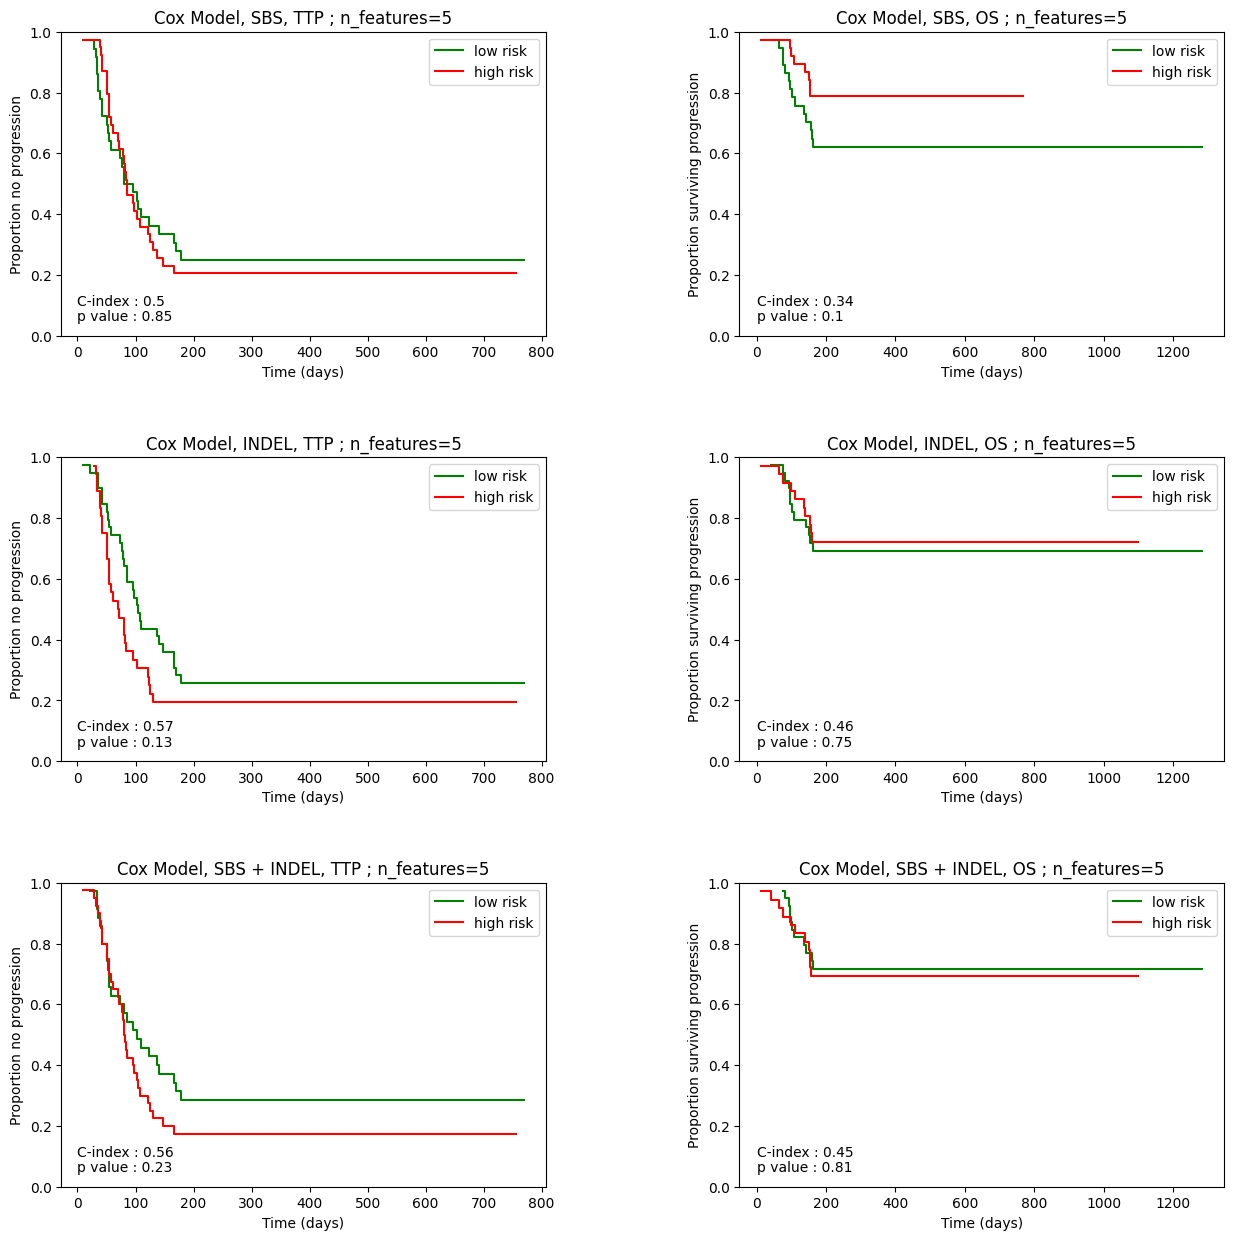

In [31]:
fig = plt.figure()

# SBS
# TTP :
ax0 = fig.add_subplot(321)
ax0.step(time_axis_low_risk_sbs_ttp, prob_axis_low_risk_sbs_ttp, where='post',color='green',label='low risk')
ax0.step(time_axis_high_risk_sbs_ttp, prob_axis_high_risk_sbs_ttp, where='post',color='red',label='high risk')
ax0.set_xlabel('Time (days)')
ax0.set_ylabel('Proportion no progression')
ax0.set_title(f'Cox Model, SBS, TTP ; n_features={n_features}')
ax0.text(0,0.1,f'C-index : {c_index_sbs_ttp}')
ax0.text(0,0.05,f'p value : {p_value_sbs_ttp}')
ax0.set_ylim(0,1)
ax0.legend()

# OS :
ax1 = fig.add_subplot(322)
ax1.step(time_axis_low_risk_sbs_os, prob_axis_low_risk_sbs_os, where='post',color='green',label='low risk')
ax1.step(time_axis_high_risk_sbs_os, prob_axis_high_risk_sbs_os, where='post',color='red',label='high risk')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Proportion surviving progression')
ax1.set_title(f'Cox Model, SBS, OS ; n_features={n_features}')
ax1.text(0,0.1,f'C-index : {c_index_sbs_os}')
ax1.text(0,0.05,f'p value : {p_value_sbs_os}')
ax1.set_ylim(0,1)
ax1.legend()

# INDEL
# TTP :
ax3 = fig.add_subplot(323)
ax3.step(time_axis_low_risk_indel_ttp, prob_axis_low_risk_indel_ttp, where='post',color='green',label='low risk')
ax3.step(time_axis_high_risk_indel_ttp, prob_axis_high_risk_indel_ttp, where='post',color='red',label='high risk')
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Proportion no progression')
ax3.set_title(f'Cox Model, INDEL, TTP ; n_features={n_features}')
ax3.text(0,0.1,f'C-index : {c_index_indel_ttp}')
ax3.text(0,0.05,f'p value : {p_value_indel_ttp}')
ax3.set_ylim(0,1)
ax3.legend()

# OS :
ax4 = fig.add_subplot(324)
ax4.step(time_axis_low_risk_indel_os, prob_axis_low_risk_indel_os, where='post',color='green',label='low risk')
ax4.step(time_axis_high_risk_indel_os, prob_axis_high_risk_indel_os, where='post',color='red',label='high risk')
ax4.set_xlabel('Time (days)')
ax4.set_ylabel('Proportion surviving progression')
ax4.set_title(f'Cox Model, INDEL, OS ; n_features={n_features}')
ax4.text(0,0.1,f'C-index : {c_index_indel_os}')
ax4.text(0,0.05,f'p value : {p_value_indel_os}')
ax4.set_ylim(0,1)
ax4.legend()

# SBS + INDEL
# TTP :
ax6 = fig.add_subplot(325)
ax6.step(time_axis_low_risk_comb_ttp, prob_axis_low_risk_comb_ttp, where='post',color='green',label='low risk')
ax6.step(time_axis_high_risk_comb_ttp, prob_axis_high_risk_comb_ttp, where='post',color='red',label='high risk')
ax6.set_xlabel('Time (days)')
ax6.set_ylabel('Proportion no progression')
ax6.set_title(f'Cox Model, SBS + INDEL, TTP ; n_features={n_features}')
ax6.text(0,0.1,f'C-index : {c_index_comb_ttp}')
ax6.text(0,0.05,f'p value : {p_value_comb_ttp}')
ax6.set_ylim(0,1)
ax6.legend()

# OS :
ax7 = fig.add_subplot(326)
ax7.step(time_axis_low_risk_comb_os, prob_axis_low_risk_comb_os, where='post',color='green',label='low risk')
ax7.step(time_axis_high_risk_comb_os, prob_axis_high_risk_comb_os, where='post',color='red',label='high risk')
ax7.set_xlabel('Time (days)')
ax7.set_ylabel('Proportion surviving progression')
ax7.set_title(f'Cox Model, SBS + INDEL, OS ; n_features={n_features}')
ax7.text(0,0.1,f'C-index : {c_index_comb_os}')
ax7.text(0,0.05,f'p value : {p_value_comb_os}')
ax7.set_ylim(0,1)
ax7.legend()

plt.gcf().set_size_inches(15,15)
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


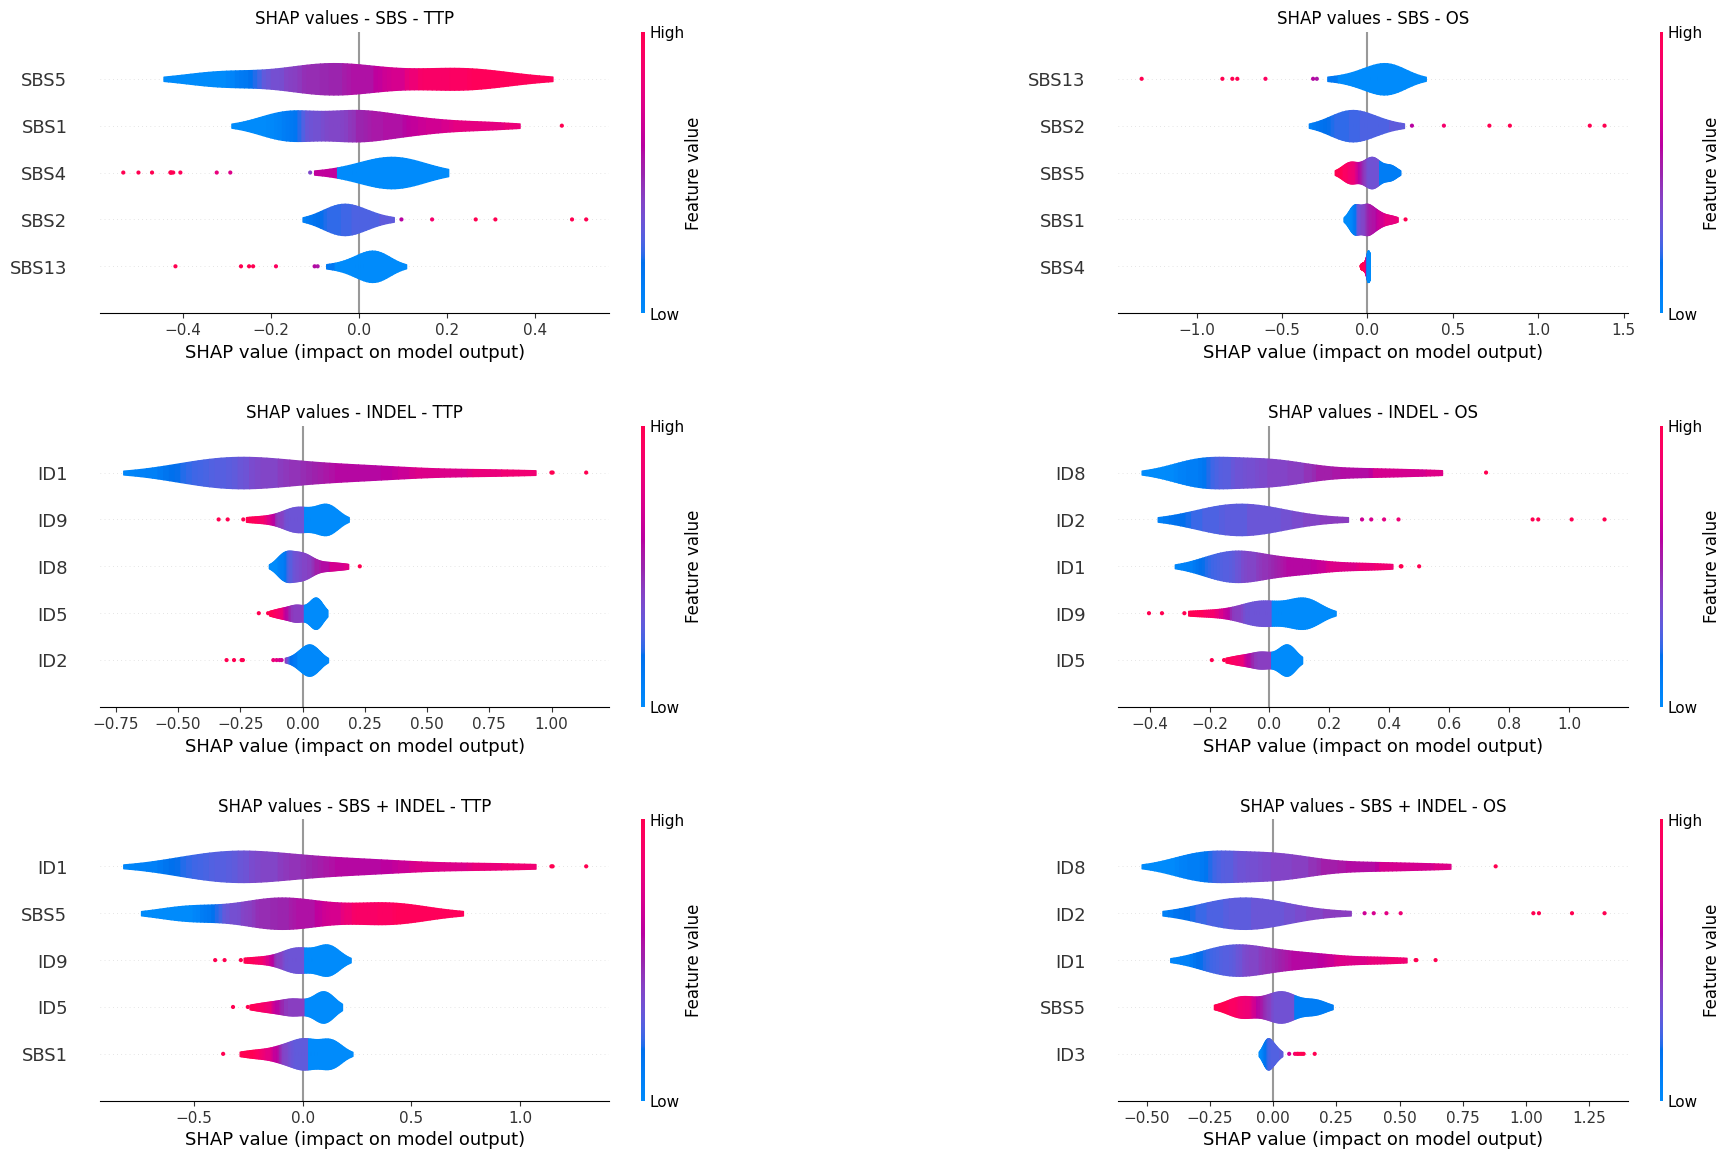

In [32]:
fig = plt.figure()

# SBS
ax2 = fig.add_subplot(321)
shap.summary_plot(shap_values_sbs_ttp, plot_type='violin', feature_names=features_name_sbs_ttp, show=False)
ax2.set_title("SHAP values - SBS - TTP")
ax22 = fig.add_subplot(322)
shap.summary_plot(shap_values_sbs_os, plot_type='violin', feature_names=features_name_sbs_os, show=False)
ax22.set_title("SHAP values - SBS - OS")

# INDEL
ax5 = fig.add_subplot(323)
shap.summary_plot(shap_values_indel_ttp, plot_type='violin', feature_names=features_name_indel_ttp, show=False)
ax5.set_title("SHAP values - INDEL - TTP")
ax52 = fig.add_subplot(324)
shap.summary_plot(shap_values_indel_os, plot_type='violin', feature_names=features_name_indel_os, show=False)
ax52.set_title("SHAP values - INDEL - OS")

# SBS + INDEL
ax8 = fig.add_subplot(325)
shap.summary_plot(shap_values_comb_ttp, plot_type='violin', feature_names=features_name_comb_ttp, show=False)
ax8.set_title("SHAP values - SBS + INDEL - TTP")
ax82 = fig.add_subplot(326)
shap.summary_plot(shap_values_comb_os, plot_type='violin', feature_names=features_name_comb_os, show=False)
ax82.set_title("SHAP values - SBS + INDEL - OS")

plt.gcf().set_size_inches(20,15)
plt.subplots_adjust(hspace=0.4,wspace=0.6)
plt.show()